# Calculate reference stress for each temperature at each strain rate

For each condition, calculate take the stress where strain is smaller than 0.08 and divide it by the reference stress at 298.15K

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [43]:
ref_temp = '298.15'

#First set, comment out second set to generate for this one
strain_rates = [0.0001]
temps = ['77.15', '233.15']

#Second set
strain_rates = [0.0001, 0.001, 0.01, 0.1]
temps = ['373.15', '473.15', '573.15', '673.15']

#Third set
strain_rates = [0.0001, 0.001, 0.01, 0.1,1]
temps = ['298.15']


for temp in temps:
    # Initialize DataFrame with strain column for the current temperature
    df = None  # Initialize df to None to handle it dynamically for each temperature
    
    for strain_rate in strain_rates:
        # Load stress data for the current temperature and strain rate
        data_RD = pd.read_csv(f'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')
        
        if df is None:
            # Initialize DataFrame with strain column if not already done
            df = pd.DataFrame({'strain': data_RD['Strain']})
        
        # Add stress data for the current strain rate as a new column
        df[f'StrRt{strain_rate}'] = data_RD['Stress']

    # Filter the DataFrame for strain values below 0.08
    #df = df[df['strain'] < 0.08]
    
    # Save the DataFrame to a CSV file for the current temperature
    output_file_path = f"Tmp{temp}_RD.csv"
    df.to_csv(output_file_path, index=False)


# Find parameters for strain rate function

In [57]:
def fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns):
    """
    Fits strain rate dependency for each row in a dataset and exports results.
    
    Parameters:
    - temperature_file (str): Path to the CSV file containing the data for a specific temperature.
    - strain_rates (list of float): List of strain rate values corresponding to columns in the dataset.
    - strain_rate_columns (list of str): List of column names in the data corresponding to strain rates.
    
    Output:
    - CSV file with columns: PEEQ, C1, C2, R_squared for each row in the dataset.
    """
    # Load the temperature-specific file
    data = pd.read_csv(f"{temperature_file}.csv")
    
    # Default rows to plot
    plot_indices = [3, 4, 5, 6, 11]
    
    # Define a scaling factor for better readability in the plot legend
    scale_factor = 1e8

    # Define the strain-rate dependency function
    def strain_rate_dependent_stress(strain_rate, C1, C2, stress_values):
        return np.array([s * (C1 * np.log(sr) + C2) for s, sr in zip(stress_values, strain_rate)])

    # List to store the results
    results = []

    # Loop through all rows in the dataset for strain-rate dependency fitting
    for i in range(len(data)):
        # Extract stress data for the specified strain rates at row `i`
        stress_values = data.iloc[i][strain_rate_columns].values  # Select specified strain rate columns
        plastic_strain = data['strain'].iloc[i]  # Get the plastic strain at this row (PEEQ)

        # Fit strain-rate dependency with evolving stress values
        initial_guess_sr = [0.1, 1]  # Adjusted initial guesses
        bounds_sr = ([0, 0], [np.inf, np.inf])  # Tighter bounds to avoid non-physical values
        
        # Perform the curve fitting for strain-rate dependency using evolving stress values
        try:
            params_sr, _ = curve_fit(lambda sr, C1, C2: strain_rate_dependent_stress(sr, C1, C2, stress_values),
                                     strain_rates, stress_values, p0=initial_guess_sr, bounds=bounds_sr)
        except RuntimeError:
            print(f"Could not fit strain-rate dependency for row {i}")
            continue
        
        # Calculate residuals for error estimation
        stress_fit = strain_rate_dependent_stress(strain_rates, *params_sr, stress_values)
        residuals = stress_values - stress_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((stress_values - np.mean(stress_values))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Store results for exporting
        results.append({
            "PEEQ": plastic_strain,
            "C1": params_sr[0],
            "C2": params_sr[1],
            "R_squared": r_squared
        })
        
        # Plot only for specified rows with scaled C1 and C2 in legend
        if i in plot_indices:
            plt.plot(strain_rates, stress_values, 'o', label='Data')
            plt.plot(strain_rates, stress_fit, '-', label='Fit')  # Use only original strain rates for fit plot
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
            plt.legend([f'Row {i}', f'Fit: C1={params_sr[0] * scale_factor:.2f} x 1e-8, C2={params_sr[1] * scale_factor:.2f} x 1e-8'], loc="lower right")
            plt.grid()
            plt.show()

    # Export results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"Parameters_{temperature_file}.csv", index=False)


## RT

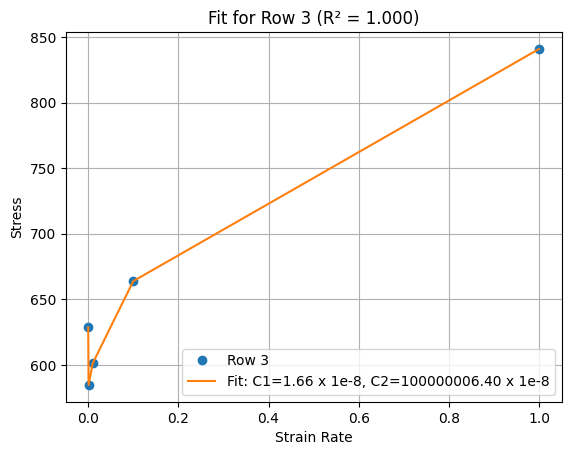

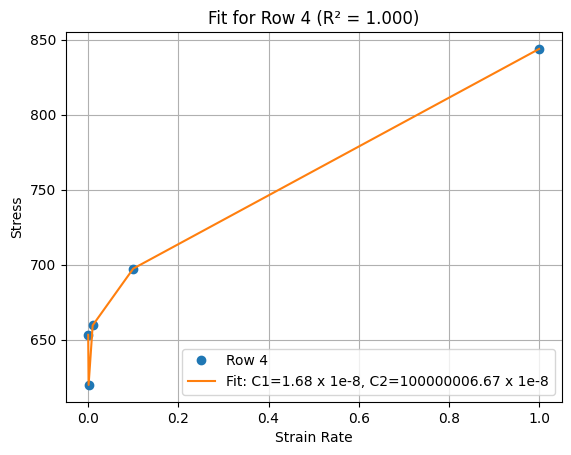

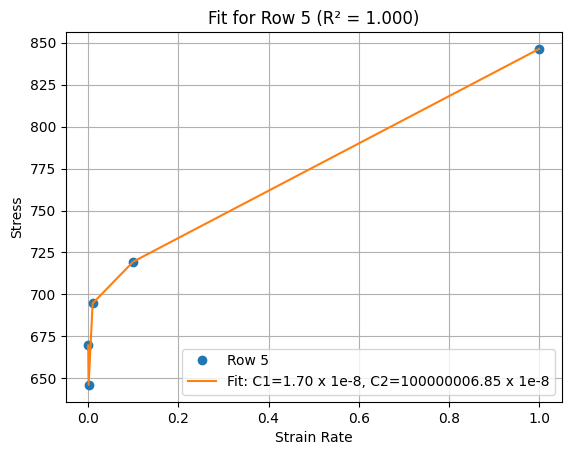

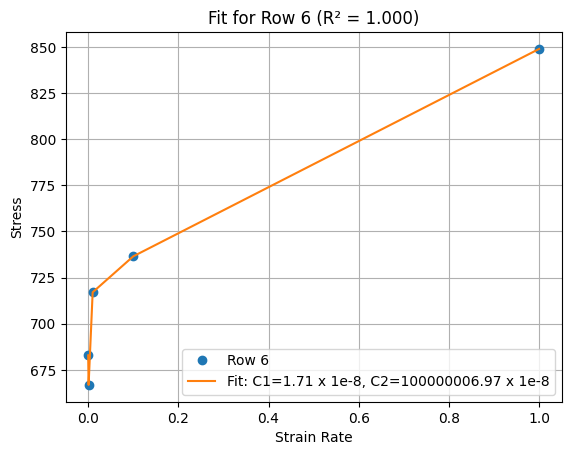

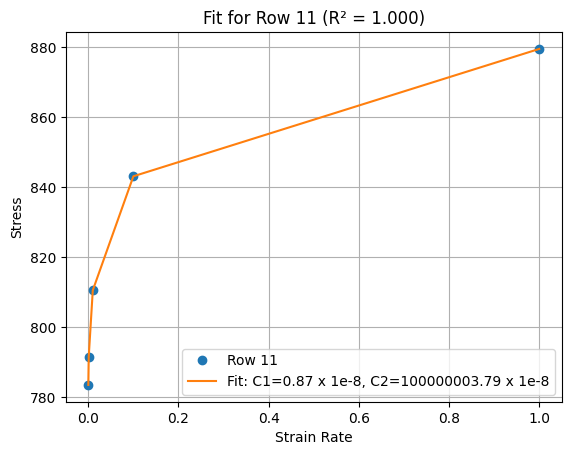

In [58]:
temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['StrR0.0001', 'StrR0.001', 'StrR0.01', 'StrR0.1', 'StrR1']

fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns)

## Other cases

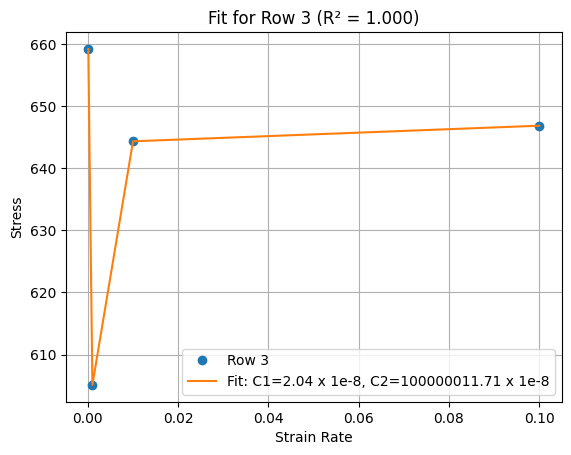

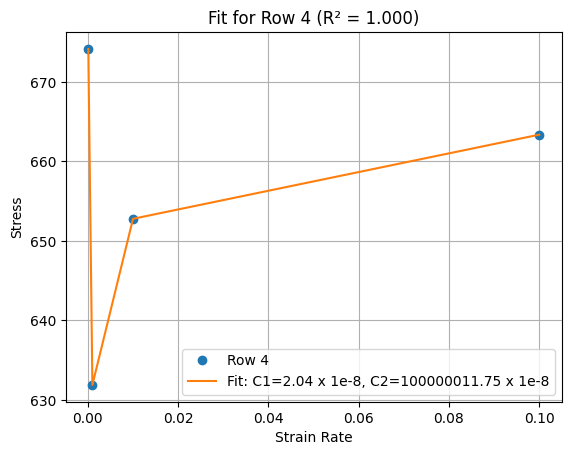

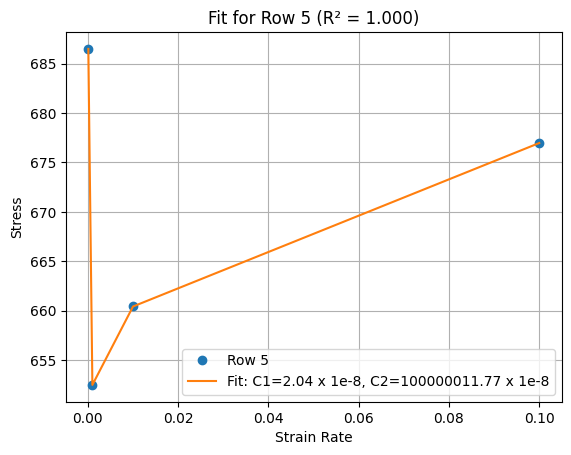

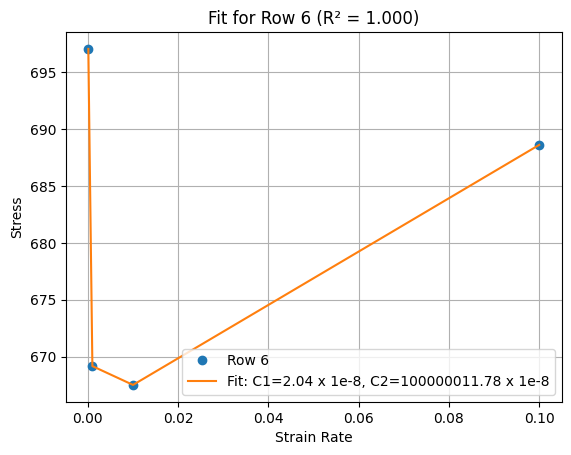

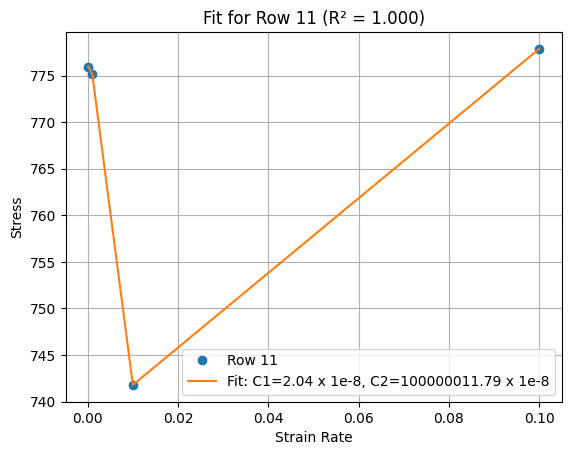

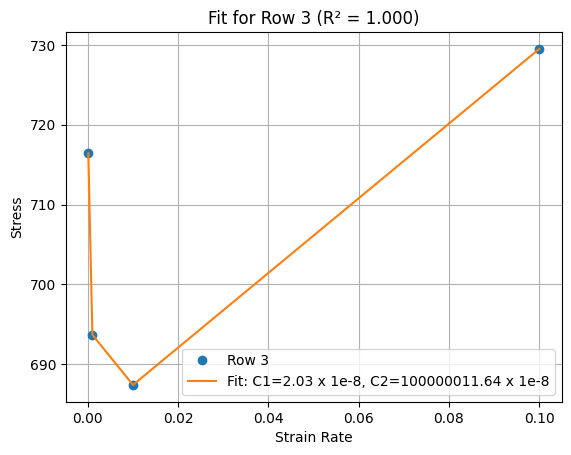

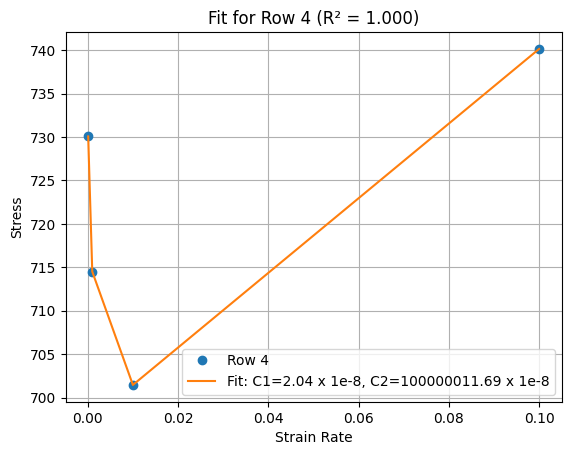

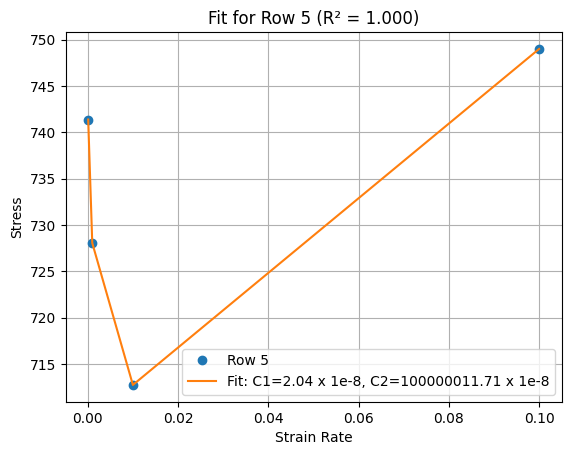

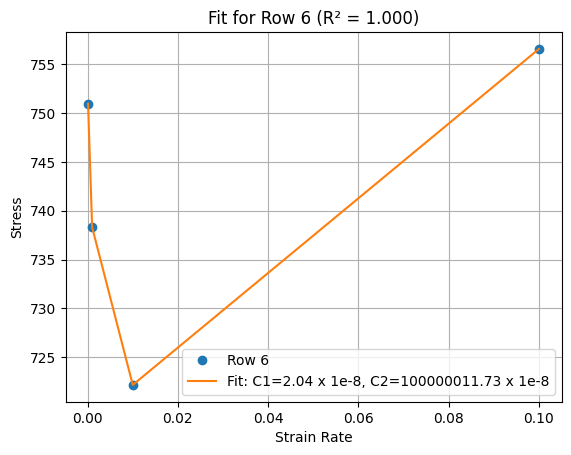

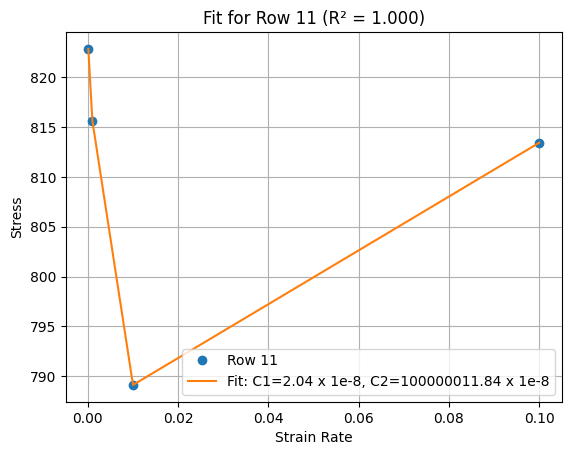

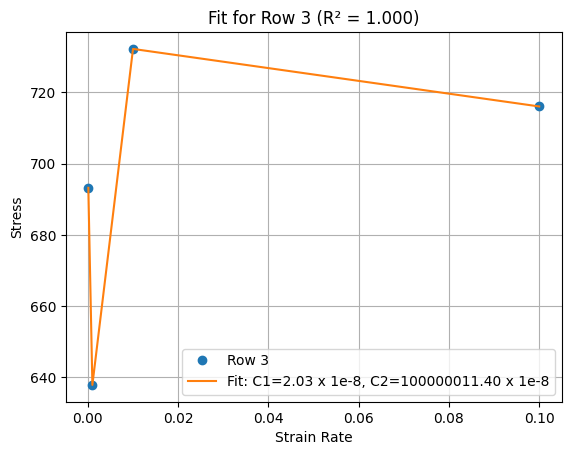

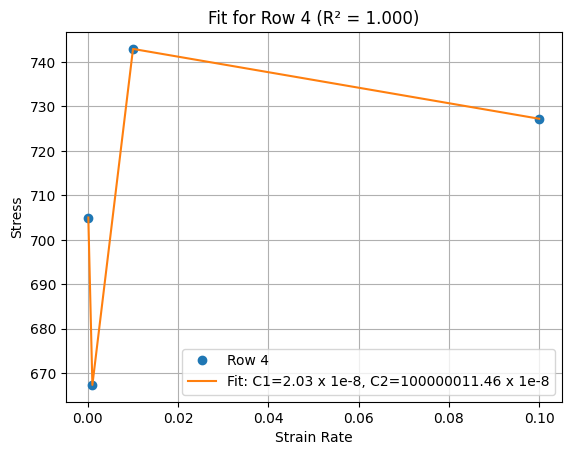

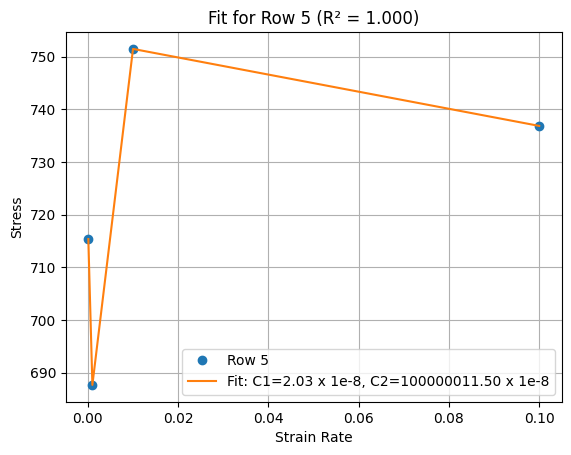

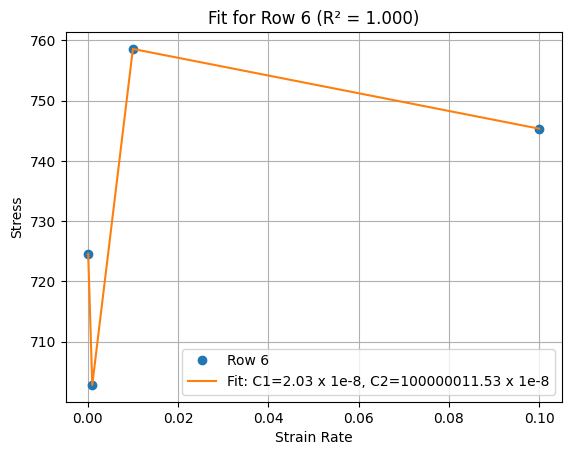

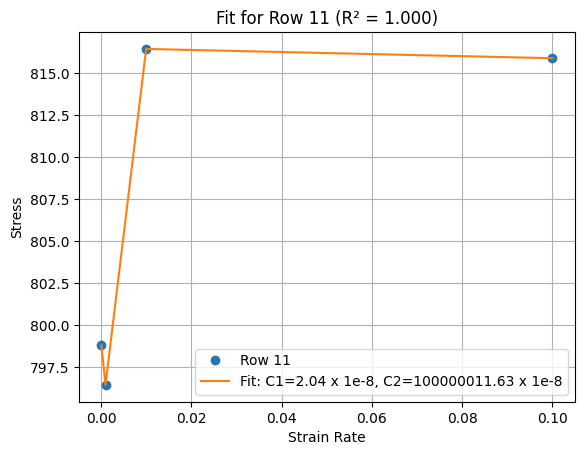

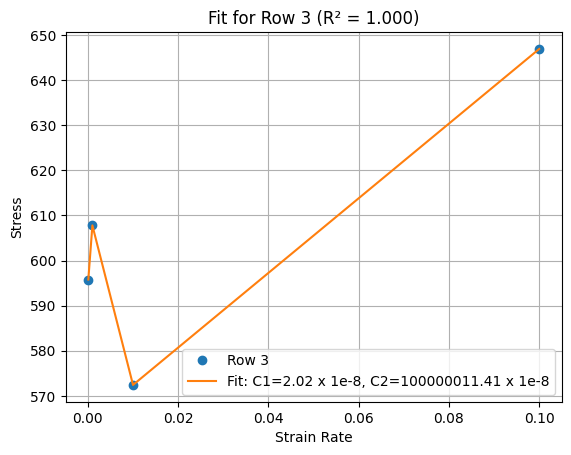

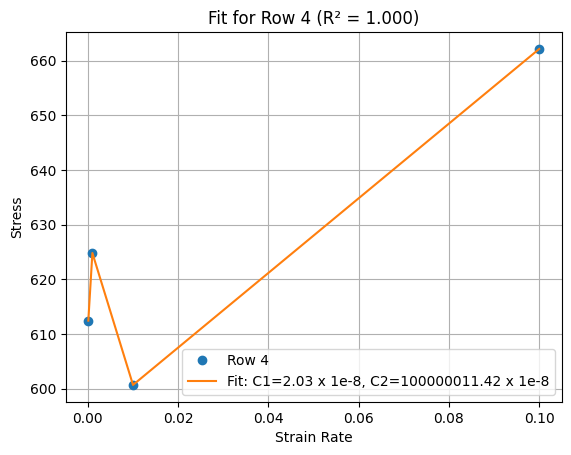

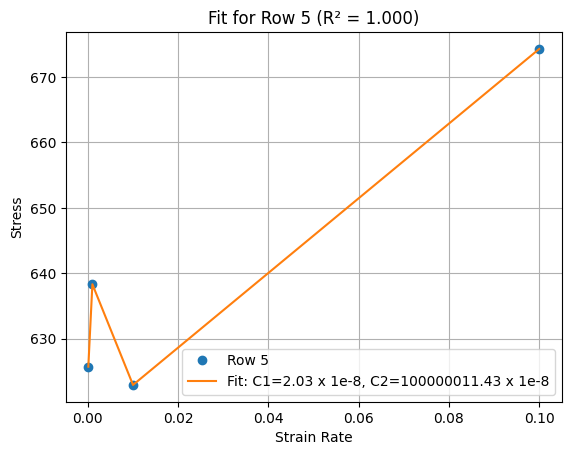

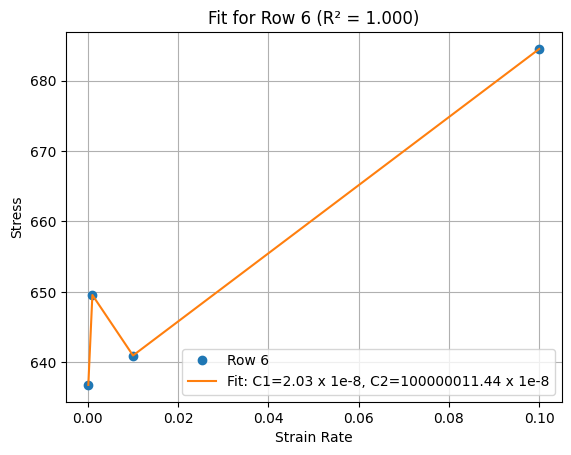

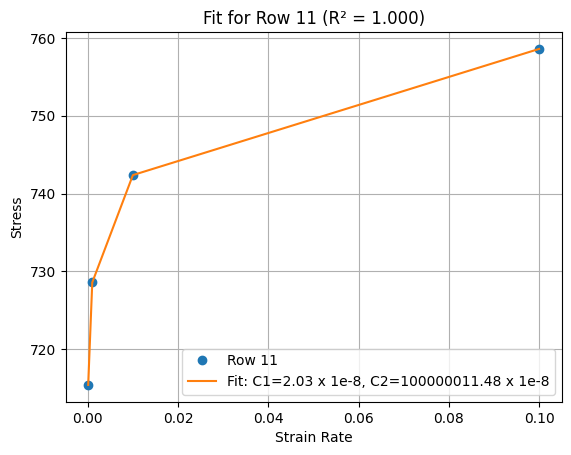

In [59]:
temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['StrR0.0001', 'StrR0.001', 'StrR0.01', 'StrR0.1']

for temp in temps:
    fit_strain_rate_dependency(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)

# Check R1 score
## Check to see if any R1 < 0.998

In [64]:
def check_r_squared(temperature_files):
    """
    Checks R_squared values in the Parameters file for each temperature and reports any below 0.99.
    
    Parameters:
    - temperature_files (list of str): List of temperature file names (without ".csv" extension).
    
    Output:
    - Prints any rows with R_squared < threshold for each temperature file.
    """
    threshold = 0.999
    for temp_file in temperature_files:
        # Load the data from the CSV file
        df = pd.read_csv(f"Parameters_{temp_file}.csv")
        
        # Filter rows where R_squared is less than 0.99
        low_r_squared = df[df['R_squared'] < threshold]
        
        if not low_r_squared.empty:
            print(f"\nTemperature File: Parameters_{temp_file}.csv")
            print(f"Rows with R_squared < {threshold}:")
            print(low_r_squared[['PEEQ', 'C1', 'C2', 'R_squared']])
        else:
            print(f"\nTemperature File: Parameters_{temp_file}.csv")
            print(f"All R_squared values are >= {threshold}.")

#Usage
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']  # List of temperature files to check
check_r_squared(temperature_files)



Temperature File: Parameters_Tmp298.15_RD.csv
All R_squared values are >= 0.999.

Temperature File: Parameters_Tmp373.15_RD.csv
All R_squared values are >= 0.999.

Temperature File: Parameters_Tmp473.15_RD.csv
All R_squared values are >= 0.999.

Temperature File: Parameters_Tmp573.15_RD.csv
All R_squared values are >= 0.999.

Temperature File: Parameters_Tmp673.15_RD.csv
All R_squared values are >= 0.999.


# Bonus

Temperature dependence

In [ ]:
ref_temp = '298.15'

#First set, comment out second set to generate for this one
strain_rates = [0.0001]
temps = ['77.15', '233.15', '298.15', '373.15', '473.15', '573.15', '673.15']

#Second set
strain_rates = [0.001, 0.01, 0.1]
temps = ['298.15', '373.15', '473.15', '573.15', '673.15']

for strain_rate in strain_rates:
    # Load reference stress data at 298.15 K for the given strain rate
    data_RD_ref = pd.read_csv(f'../extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
    ref_stress_RD = data_RD_ref['Stress']  # Stress column at reference temperature
    
    # Initialize DataFrame with strain column
    df = pd.DataFrame({'strain': data_RD_ref['Strain']})
    
    # Loop over each temperature to calculate and add normalized stress columns
    for temp in temps:
        # Load stress data at the current temperature
        temp_RD = pd.read_csv(f'../extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']
        
        # Calculate normalized stress by dividing by reference stress at 298.15 K
        normalized_stress_RD = temp_RD / ref_stress_RD
        
        # Add normalized stress as a column in the DataFrame
        df[f'Tmp{temp}K_ref'] = normalized_stress_RD

    # Save the DataFrame to a CSV file
    df = df[df['strain'] < 0.08]
    output_file_path = f"StrainRate{strain_rate}_RD.csv"
    df.to_csv(output_file_path, index=False)